In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
import numpy as np

In [8]:
# # Create a dummy CSV file for demonstration purposes
# data = {
#     'timestamp(ms)': np.linspace(1.751249e+09, 1.751249e+09 + 187*1000, 188),
#     'signal': np.sin(np.linspace(0, 4*np.pi, 188)) * 5000 + 122000 + np.random.randn(188) * 100,
#     'Unnamed: 2': np.nan
# }
# df = pd.DataFrame(data)
# df.to_csv('your_data.csv', index=False)

# Load your actual data
df = pd.read_csv('nathan_2025-1.csv', delimiter=";")

# Drop the 'Unnamed: 2' column if it's always NaN as shown
if 'Unnamed: 2' in df.columns and df['Unnamed: 2'].isnull().all():
    df = df.drop(columns=['Unnamed: 2'])

print(df.columns)

Index(['timestamp(ms)', 'signal'], dtype='object')


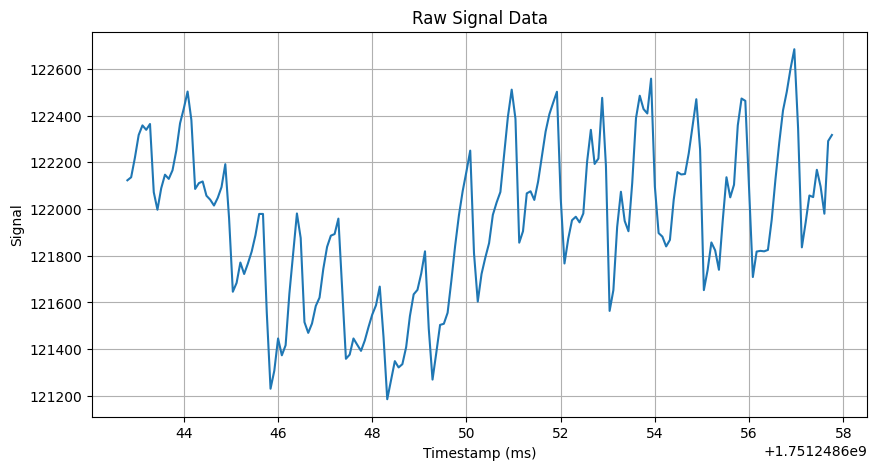

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp(ms)'], df['signal'])
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal')
plt.title('Raw Signal Data')
plt.grid(True)
plt.show()

In [10]:
# Bandpass filter parameters
lowcut = 0.5  # Hz
highcut = 8.0 # Hz (typical range for PPG, adjust if needed)
order = 4     # Filter order

nyquist = 0.5 * 100
low = lowcut / nyquist
high = highcut / nyquist

b, a = butter(order, [low, high], btype='band')
df['filtered_signal_bandpass'] = filtfilt(b, a, df['signal'])

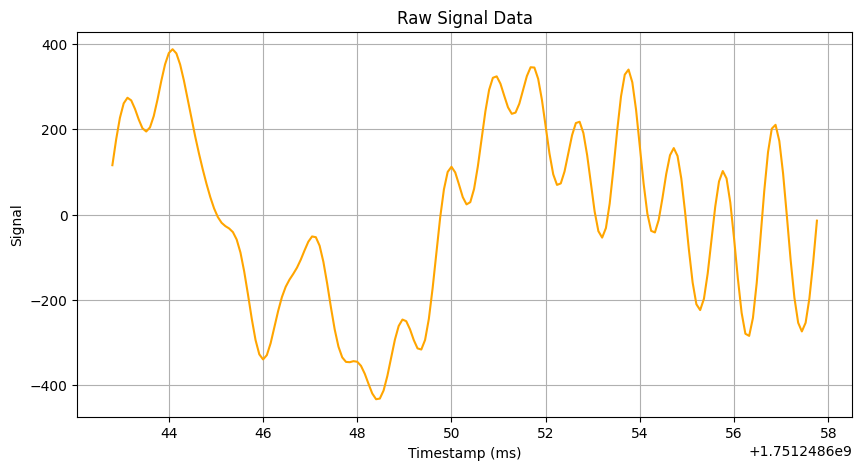

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp(ms)'], df['filtered_signal_bandpass'], color='orange')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal')
plt.title('Raw Signal Data')
plt.grid(True)
plt.show()

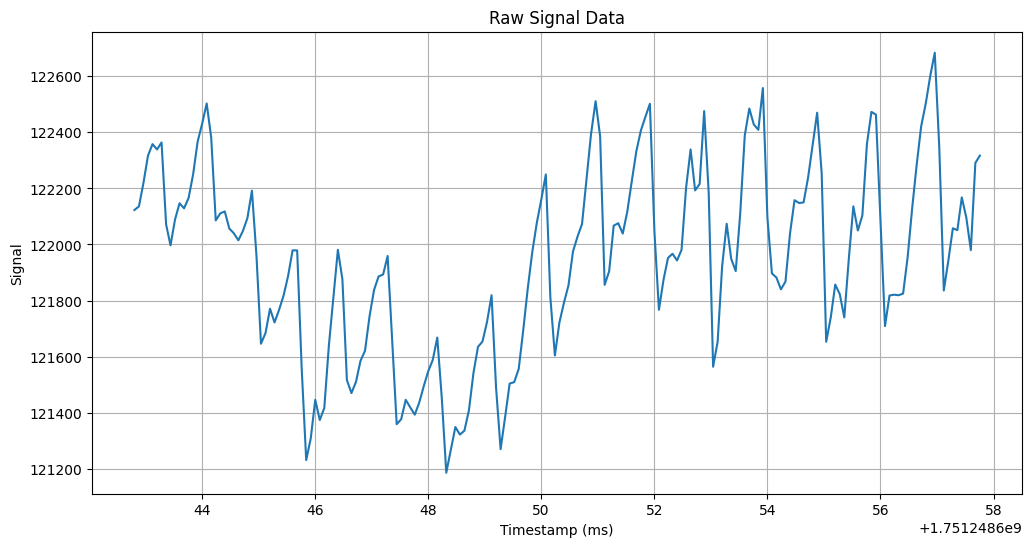

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp(ms)'], df['signal'])
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal')
plt.title('Raw Signal Data')
plt.grid(True)
plt.show()

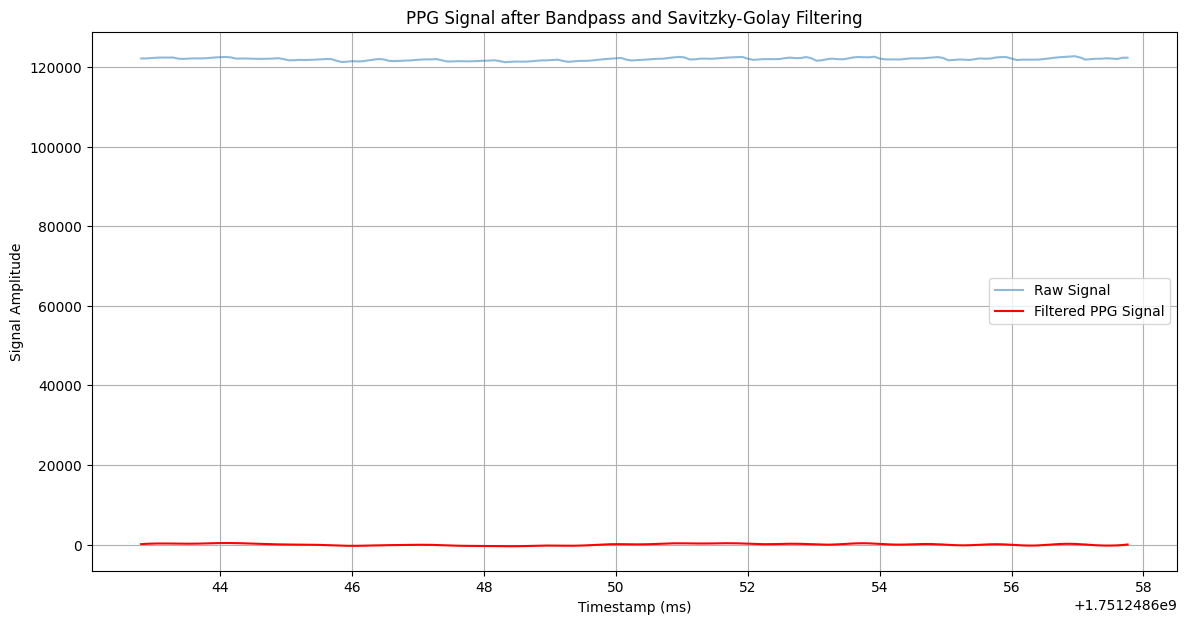

In [13]:
window_length_sg = int(0.1 * 100) # Example: 100ms window
if window_length_sg % 2 == 0: # Must be odd
    window_length_sg += 1
polyorder_sg = 3 # Polynomial order

df['filtered_signal'] = savgol_filter(df['filtered_signal_bandpass'], window_length_sg, polyorder_sg)

plt.figure(figsize=(14, 7))
plt.plot(df['timestamp(ms)'], df['signal'], label='Raw Signal', alpha=0.5)
plt.plot(df['timestamp(ms)'], df['filtered_signal'], label='Filtered PPG Signal', color='red')
plt.title('PPG Signal after Bandpass and Savitzky-Golay Filtering')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()

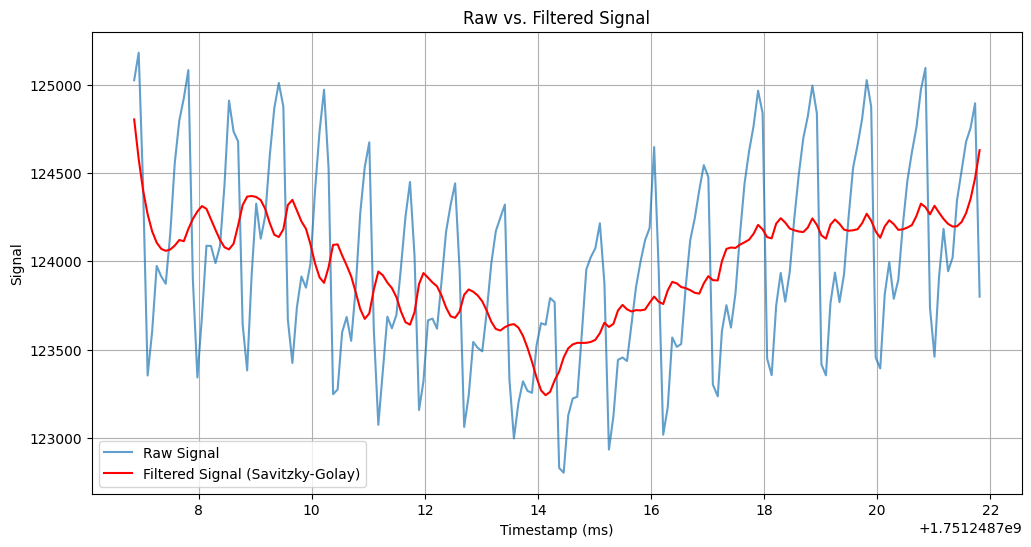

In [10]:
# Convert timestamp to a more manageable unit if needed, or just use indices for plotting
# For peak detection, the actual timestamp value might not be critical, but the order is.
# Let's use the index for now as the x-axis for filtering and initial plotting.

# Filter the signal
# Adjust window_length and polyorder based on your signal's characteristics
window_length = 21  # Must be an odd number
polyorder = 3       # Must be less than window_length

# Ensure window_length is not greater than the number of data points
if len(df) < window_length:
    window_length = len(df) - 1 if len(df) % 2 == 0 else len(df) # Make it odd and smaller than data length
    if window_length < 3: # Ensure minimum for polyorder 1
        window_length = 3
    print(f"Adjusted window_length to {window_length} due to small data size.")


df['filtered_signal'] = savgol_filter(df['signal'], window_length, polyorder)

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp(ms)'], df['signal'], label='Raw Signal', alpha=0.7)
plt.plot(df['timestamp(ms)'], df['filtered_signal'], label='Filtered Signal (Savitzky-Golay)', color='red')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal')
plt.title('Raw vs. Filtered Signal')
plt.legend()
plt.grid(True)
plt.show()

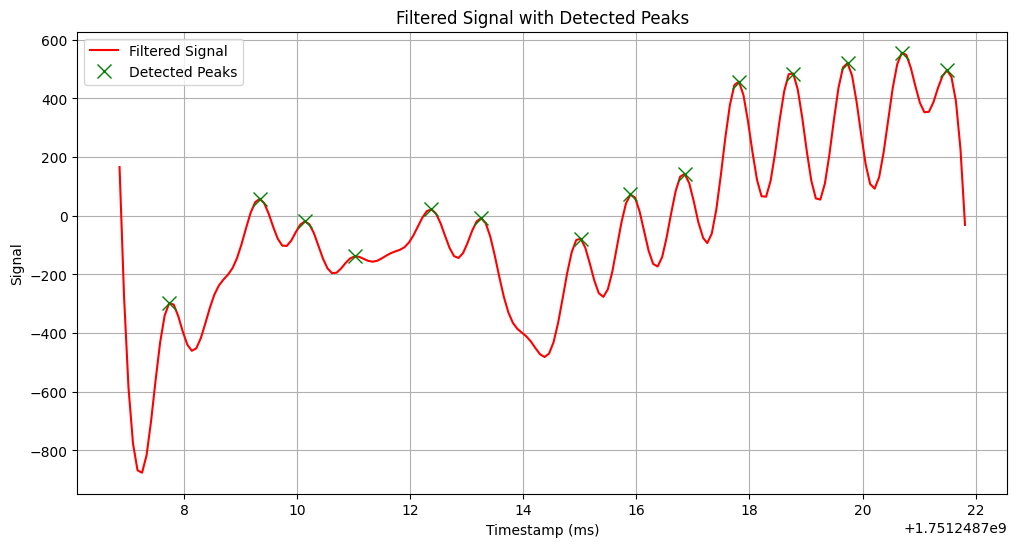

Detected 14 peaks.
Peak indices: [ 11  31  41  52  69  80 102 113 125 137 149 161 173 183]
Peak values (signal): [-297.52051502   57.92648959  -18.82953543 -138.27527968   22.03852579
   -8.06973673  -78.04088954   72.71388968  143.01983188  457.3151889
  485.07276861  520.62791817  556.00778333  496.19212558]
Peak timestamps (ms): [1.75124871e+09 1.75124871e+09 1.75124871e+09 1.75124871e+09
 1.75124871e+09 1.75124871e+09 1.75124872e+09 1.75124872e+09
 1.75124872e+09 1.75124872e+09 1.75124872e+09 1.75124872e+09
 1.75124872e+09 1.75124872e+09]


In [18]:
# Detect peaks on the filtered signal
# Experiment with 'distance', 'height', and 'prominence'
# 'distance' ensures peaks are a certain number of samples apart
# 'height' can set a minimum signal value for a peak
# 'prominence' is often very useful for finding "significant" peaks

# Example parameters - you'll need to tune these
# Let's try to estimate a reasonable distance based on visual inspection or data characteristics
# For example, if you expect peaks to be at least 10 samples apart:
min_peak_distance = 10 # Adjust as needed
# min_peak_height = 122200 # Adjust if you know a minimum signal value for a peak
# min_peak_prominence = 50 # Adjust as needed

peaks, properties = find_peaks(df['filtered_signal'], distance=min_peak_distance) # , height=min_peak_height, prominence=min_peak_prominence)

# If you want to use height or prominence, uncomment and adjust:
# peaks, properties = find_peaks(df['filtered_signal'], distance=min_peak_distance, height=min_peak_height, prominence=min_peak_prominence)


plt.figure(figsize=(12, 6))
plt.plot(df['timestamp(ms)'], df['filtered_signal'], label='Filtered Signal', color='red')
plt.plot(df['timestamp(ms)'].iloc[peaks], df['filtered_signal'].iloc[peaks], "x", markersize=10, color='green', label='Detected Peaks')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Signal')
plt.title('Filtered Signal with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()

print(f"Detected {len(peaks)} peaks.")
print("Peak indices:", peaks)
print("Peak values (signal):", df['filtered_signal'].iloc[peaks].values)
print("Peak timestamps (ms):", df['timestamp(ms)'].iloc[peaks].values)

# You can also access other properties if you used them in find_peaks, e.g., properties['peak_heights']

In [18]:
peak_timestamps = df['timestamp(ms)'].iloc[peaks].values
peak_signal_values = df['filtered_signal'].iloc[peaks].values

peak_data = pd.DataFrame({
    'peak_timestamp_ms': peak_timestamps,
    'peak_signal_value': peak_signal_values
})

print("\nPeak Data:")
print(peak_data)


Peak Data:
    peak_timestamp_ms  peak_signal_value
0        1.751249e+09      124312.305982
1        1.751249e+09      124369.406342
2        1.751249e+09      124095.905525
3        1.751249e+09      123933.598889
4        1.751249e+09      123840.762994
5        1.751249e+09      123644.696633
6        1.751249e+09      123538.882314
7        1.751249e+09      123753.389997
8        1.751249e+09      123883.724747
9        1.751249e+09      124077.893102
10       1.751249e+09      124243.905852
11       1.751249e+09      124269.035959
12       1.751249e+09      124326.288003
